In [19]:
#lib imported
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D,BatchNormalization,UpSampling1D,Conv1DTranspose,Dense,Flatten,Attention, Add, Multiply, Activation
from tensorflow.keras.models import Sequential,Model
from mat4py import loadmat
from tensorflow.keras.optimizers import Adam,SGD
import scipy.io
from biosppy.signals import ecg
from scipy import signal
from keras import backend as K
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from ecgdetectors import Detectors
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import pywt
import random

In [20]:
def normalize_ecg(ecg_signal):
    """
    Normalize the ECG signal using min-max normalization
    """
    # Find the minimum and maximum values of the signal
    min_val = np.min(ecg_signal)
    max_val = np.max(ecg_signal)

    # Normalize the signal using min-max normalization
    normalized_ecg = (ecg_signal - min_val) / (max_val - min_val)

    return normalized_ecg

In [21]:
mat = scipy.io.loadmat('101m.mat')


In [22]:
aa=mat['val']
a=aa[0,0:]
a=normalize_ecg(a)
a.shape

(650000,)

In [23]:
# Original sampling rate and desired new sampling rate
original_sampling_rate =360    # Replace with your actual sampling rate
new_sampling_rate = 250  # Desired new sampling rate

# Calculate the new length of the resampled signal
original_length = len(a)
new_length = int(original_length * (new_sampling_rate / original_sampling_rate))

# Resample the signal
r_ecg = signal.resample(a, new_length)

In [24]:
r_ecg.shape

(451388,)

In [25]:
out = ecg.christov_segmenter(signal=r_ecg, sampling_rate=250)
rpeaks = out['rpeaks']

In [26]:
segment_length = 600  # Fixed segment length of 600 data points
window_size_seconds = 2.4  # Time window of 2.4 seconds
segments = []


for i in range(0, len(rpeaks) - 3, 2):  # Step by 2 to get two R-peaks per segment
    rpeak1 = rpeaks[i]
    rpeak2 = rpeaks[i + 1]
    
    # Calculate the midpoint between the two R-peaks
    midpoint = (rpeak1 + rpeak2) // 2
    
    # Calculate the segment start and end indices for the specified window size
    window_size_samples = int(250 * window_size_seconds)
    segment_start = max(0, midpoint - window_size_samples // 2)
    segment_end = segment_start + segment_length
    
    # Check if segment_end goes beyond the signal length
    if segment_end > len(r_ecg):
        # Perform zero-padding if necessary
        segment = np.pad(r_ecg[segment_start:], (0, segment_end - len(r_ecg)))
    else:
        segment = r_ecg[segment_start:segment_end]
    
    segments.append(segment)

In [27]:
data=np.array(segments)
# data1=data.reshape((200,300))
data.shape

(75, 600)

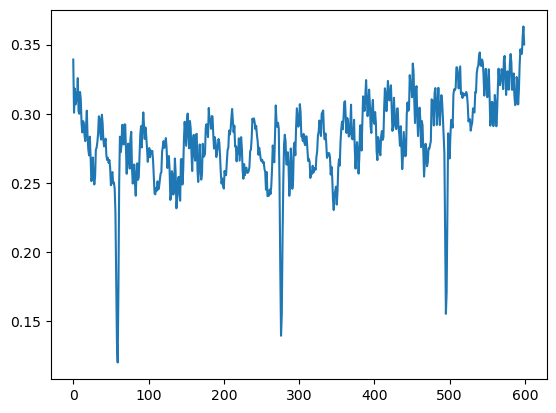

In [28]:
plt.plot(data[0])

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LeakyReLU, Conv1DTranspose, Multiply, Add, Dense

# Create a Sequential model
model = tf.keras.Sequential()

# Encoder
model.add(Conv1D(16, kernel_size=13, padding='same', input_shape=(600, 1)))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(2))

model.add(Conv1D(32, kernel_size=7, padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(2))

model.add(Conv1D(64, kernel_size=7, padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(2))

model.add(Conv1D(128, kernel_size=7, padding='same'))
model.add(LeakyReLU(alpha=0.2))

# Initialize the attention weights
# attention_weights = None

# Transposed Convolution 1
model.add(Conv1DTranspose(128, kernel_size=7, padding='same'))
model.add(LeakyReLU(alpha=0.2))

# ECA Module 1
attention_weights = Conv1D(128, kernel_size=3, padding='same')(model.layers[-1].output)
attention_weights = tf.keras.layers.Activation('sigmoid')(attention_weights)
attended_features = Multiply()([model.layers[-1].output, attention_weights])
output = Add()([model.layers[-1].output, attended_features])

# Transposed Convolution 2
model.add(Conv1DTranspose(64, kernel_size=7, padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(UpSampling1D(2))

# ECA Module 2
attention_weights = Conv1D(64, kernel_size=3, padding='same')(model.layers[-1].output)
attention_weights = tf.keras.layers.Activation('sigmoid')(attention_weights)
attended_features = Multiply()([model.layers[-1].output, attention_weights])
output = Add()([model.layers[-1].output, attended_features])

# Transposed Convolution 3
model.add(Conv1DTranspose(32, kernel_size=7, padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(UpSampling1D(2))

# ECA Module 3
attention_weights = Conv1D(32, kernel_size=3, padding='same')(model.layers[-1].output)
attention_weights = tf.keras.layers.Activation('sigmoid')(attention_weights)
attended_features = Multiply()([model.layers[-1].output, attention_weights])
output = Add()([model.layers[-1].output, attended_features])

# Transposed Convolution 4
model.add(Conv1DTranspose(16, kernel_size=13, padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(UpSampling1D(2))

# Dense Layer 1
model.add(Dense(1, activation='linear'))  # You may need to adjust the number of units

# Summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 600, 16)           224       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 600, 16)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 300, 16)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 300, 32)           3616      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 300, 32)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 150, 32)          0         
 1D)                                                  

In [30]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv1D, LeakyReLU, Conv1DTranspose, Multiply, Add, Dense

# # Create a Sequential model
# model = tf.keras.Sequential()

# # Encoder
# model.add(Conv1D(16, kernel_size=13, padding='same', input_shape=(600, 1)))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(2))

# model.add(Conv1D(32, kernel_size=7, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(2))

# model.add(Conv1D(64, kernel_size=7, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(2))

# model.add(Conv1D(128, kernel_size=7, padding='same'))
# model.add(LeakyReLU(alpha=0.2))

# # Initialize the attention weights
# # attention_weights = None

# # Transposed Convolution 1
# model.add(Conv1DTranspose(128, kernel_size=7, padding='same'))
# model.add(LeakyReLU(alpha=0.2))


# model.add(Conv1D(128, kernel_size=3, padding='same'))

# # Transposed Convolution 2
# model.add(Conv1DTranspose(64, kernel_size=7, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(UpSampling1D(2))


# model.add(Conv1D(64, kernel_size=3, padding='same'))

# # Transposed Convolution 3
# model.add(Conv1DTranspose(32, kernel_size=7, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(UpSampling1D(2))


# model.add(Conv1D(32, kernel_size=3, padding='same'))

# # Transposed Convolution 4
# model.add(Conv1DTranspose(16, kernel_size=13, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(UpSampling1D(2))



# # Dense Layer 1
# model.add(Dense(1, activation='linear'))  # You may need to adjust the number of units

# # Summary of the model architecture
# model.summary()

In [31]:
Y_train, Y_test = train_test_split(data, test_size=0.2)
Y_test.shape
y=len(Y_test)

In [32]:
# #parameters_compilation
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
adm= Adam(learning_rate=0.0001)
model.compile(optimizer=adm ,loss=root_mean_squared_error,metrics=["mae"])
#sgd= SGD(learning_rate=0.01)
#model.compile(optimizer=sgd, loss=root_mean_squared_error,metrics=["mae", "acc"])
# model.compile(optimizer=adm ,loss='binary_crossentropy',metrics=[ "acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 600, 16)           224       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 600, 16)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 300, 16)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 300, 32)           3616      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 300, 32)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 150, 32)          0         
 1D)                                                  

In [33]:
model.fit(Y_train,Y_train,batch_size=32,epochs=50)

Epoch 1/50
2/2 [==============================] - 6s 140ms/step - loss: 0.3460 - mae: 0.3434
Epoch 2/50
2/2 [==============================] - 0s 130ms/step - loss: 0.3151 - mae: 0.3126
Epoch 3/50
2/2 [==============================] - 0s 127ms/step - loss: 0.2828 - mae: 0.2801
Epoch 4/50
2/2 [==============================] - 0s 127ms/step - loss: 0.2409 - mae: 0.2378
Epoch 5/50
2/2 [==============================] - 0s 127ms/step - loss: 0.1849 - mae: 0.1802
Epoch 6/50
2/2 [==============================] - 0s 130ms/step - loss: 0.1143 - mae: 0.1035
Epoch 7/50
2/2 [==============================] - 0s 132ms/step - loss: 0.0691 - mae: 0.0482
Epoch 8/50
2/2 [==============================] - 0s 129ms/step - loss: 0.1086 - mae: 0.1024
Epoch 9/50
2/2 [==============================] - 0s 130ms/step - loss: 0.1036 - mae: 0.0970
Epoch 10/50
2/2 [==============================] - 0s 132ms/step - loss: 0.0696 - mae: 0.0549
Epoch 11/50
2/2 [==============================] - 0s 124ms/step - lo

In [34]:
pred=model.predict(Y_test)
pred.shape

(15, 600, 1)

In [35]:
pred=np.reshape(pred,(y,600))

In [36]:
p1=0
s1=0;
for x in range(y):
    rec1=pred[x]
    xtrn1=Y_test[x]
    actual= xtrn1
    predicted= rec1
    sme= np.sum(np.square(actual - predicted))
    org = np.sum(np.square(actual))
    prd1= np.sqrt(sme/org)*100
    p1=p1+prd1;
    signal_power = np.sum(actual ** 2) / len(actual)
    noise_signal = actual-predicted
    noise_power = np.sum(noise_signal ** 2) / len(noise_signal)
    snr_db = 10 * np.log10(signal_power / noise_power)
    s1=s1+snr_db;

prd=p1/y;
snr_d=s1/y;
print("PRD:",prd) 
print("SNR:",snr_d)
    
    

PRD: 6.872339113079013
SNR: 23.304591688566358
